**Description:** Positional length control. No length prediction. Ground Truth length is used as input to decoder for absolute positional encoding

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
import inspect

In [4]:
sys.path.append("../scripts/")

In [5]:
import json

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [30]:
import random
from collections import defaultdict

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (10, 8)

In [9]:
from transformers import Seq2SeqTrainer

In [10]:
from sinusodial_positional_embedding import SinusoidalPositionalEmbedding

In [11]:
from tqdm import tqdm
import torch
import analysis_utils
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from dataset import CitationTextGenerationDataset, CitationTextGenerationDatasetNoCitationType
from torch.utils.data import Dataset, DataLoader

from modelling_led import LEDForConditionalGeneration

In [12]:
device = "cuda"

In [13]:
max_input_length = 16384
max_output_length = 1024

In [14]:
def process_data_to_model_inputs(batch, special_tokens=['[Dominant]', '[Reference]'], length=None):
    # tokenize the inputs and labels
    
    additional_special_tokens_lookup = {token: idx for token, idx in zip(tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids)}
    special_token_ids = set([additional_special_tokens_lookup[token] for token in special_tokens])
    special_token_ids.add(tokenizer.mask_token_id)
    
    inputs = tokenizer(
        batch["source"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        add_special_tokens=True 
    )
    outputs = tokenizer(
        batch["target"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
        add_special_tokens=True 
    )
    if length:
        batch["length"] = length
    else:
        batch["length"] = [sum(x) for x in outputs.attention_mask]


    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    for i_batch in range(len(batch["input_ids"])):
        for i_token in range(len(batch["input_ids"][0])):
            if batch["input_ids"][i_batch][i_token] in special_token_ids:
                batch["global_attention_mask"][i_batch][i_token] = 1
            
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]
    return batch

In [15]:
path = "/home/bxm200000/models/dominant_only/led_generations/positional_length_control_v8_dominant_only/checkpoint-67500/"

In [16]:
tokenizer = AutoTokenizer.from_pretrained(path)
special_tokens = ['<doc>','</doc>', '[BOS]', '[Mask]', '[Dominant]', '[Reference]', '[B_Dominant]',  '[E_Dominant]', '[B_Reference]', '[E_Reference]']
# special_tokens = ['<doc>','</doc>', '[BOS]', '[Mask]', '[B_Mask]',  '[E_Mask]']
additional_special_tokens = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(additional_special_tokens)

0

In [17]:
model = LEDForConditionalGeneration.from_pretrained(
    path
)

In [18]:
model.config.sinpostype

'absolute'

In [19]:
model = model.to(device).half()
model.eval()

LEDForConditionalGeneration(
  (led): LEDModel(
    (shared): Embedding(50275, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50275, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768, padding_idx=1)
      (layers): ModuleList(
        (0): LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bias=True)
        

In [20]:
val_set = CitationTextGenerationDatasetNoCitationType(
    "/home/data/XiangciLi/CORWA/annotated_test/", 
    tokenizer, 
    MAX_SENT_LEN = max_input_length,
    related_work_path='/home/data/XiangciLi/20200705v1/acl/selected_related_work.jsonl',
    cited_metadata_path='/home/data/XiangciLi/20200705v1/acl/selected_cited_metadata.jsonl',
    cited_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_cited_pdf_parses.jsonl",
    citing_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_pdf_parses.jsonl",
    skip_no_citations = True,
    include_intro = False
)

100%|██████████| 362/362 [00:08<00:00, 43.87it/s]


In [21]:
def get_citations(src):
    """Get citations given source content"""
    all_citations = []
    for cite_data in src.split("[B_Reference]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())

    for cite_data in src.split("[B_Dominant]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
        
    for cite_data in src.split("[B_Mask]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
    
    return all_citations

In [22]:
def get_sentence_token_count(sent):
    return tokenizer.tokenize(sent).__len__()

In [23]:
val_set.filter_citation_type('Dominant')


avg_1 = np.mean([get_sentence_token_count(x["target"]) for x in val_set if len(get_citations(x["source"]) ) == 1])
avg_1 = int(avg_1)

avg_2 = np.mean([get_sentence_token_count(x["target"]) for x in val_set if len(get_citations(x["source"]) ) == 2])
avg_2 = int(avg_2)

avg_greater_2 = np.mean([get_sentence_token_count(x["target"]) for x in val_set if len(get_citations(x["source"]) ) == 4])
avg_greater_2 = int(avg_greater_2)

all_lengths = [get_sentence_token_count(x["target"]) for x in val_set]

avg_length = int(np.mean(all_lengths))
avg_length

42

In [31]:
def get_random_length():
    return random.choice(all_lengths)

In [24]:
def get_context(source):
    return source.split("\n\n")[0]

In [25]:
def get_context_sentence_avg_length(source):
    context = get_context(source)
    sentences = context.split("\n")
    return np.mean([len(x) for x in sentences])

In [26]:
def get_desired_length(source):
    cit_count = get_citations(source).__len__()
    if cit_count ==1 :
        return avg_1
    elif cit_count == 2:
        return avg_2
    elif cit_count == 0:
        print("Warning: citation count is 0")
        return avg_length
    return avg_greater_2

In [27]:
def get_span_avg_length(idd):
    return span_length_dict[get_id(idd)]

In [28]:
samples = []
for sample in val_set.samples:
    source = sample["source"]
    source = source.replace("[B_Mask]", "[B_Dominant]")
    source = source.replace("[E_Mask]", "[E_Dominant]")
    sample["source"] = source
    samples.append(sample)

val_set.samples = samples

In [ ]:
#reference_predicted = []
#reference_reference = []
#dominant_predicted = []
#dominant_reference = []
accumulated_data = []               # store all generation data
for batch in tqdm(DataLoader(val_set, batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=['[Mask]'], 
        length=get_random_length()
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)

    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}
    predicted_abstract_ids = model.generate(
        input_ids = processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        **model_kwargs,
    )    
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=True)
    target = batch["target"]
    for o, t, part_id, source in zip(out, target, batch["id"], batch["source"]):
        accumulated_data.append(
            {"source": source, "target": t, 
             "generated": o, "part_id": part_id}
        )

 59%|█████▊    | 775/1322 [40:24<27:01,  2.96s/it]  

In [ ]:
for data, val_data in zip(accumulated_data, val_set):
    data["citation_type"] = val_data["citation_type"]

In [ ]:
path

In [ ]:
analysis_utils.write_json(
    accumulated_data,
    os.path.abspath(os.path.join(path, "../sample_output_random_sampled_length.json"))
)

In [58]:
json_path = '/home/bxm200000/models/dominant_only/led_generations/span_v1_cdlm/sample_output.json'

In [59]:
accumulated_data = analysis_utils.load_json(
    json_path
)

In [48]:
# accumulated_data = analysis_utils.load_json(
#     os.path.abspath(os.path.join(path, "../sample_output_length_ground_truth.json"))
# )

### Difference in Length of generation and ground truth

In [55]:
def get_length_difference(data, tokenizer=tokenizer):
    """"""
    return tokenizer.tokenize(data["target"]).__len__() - tokenizer.tokenize(data["generated"]).__len__()
    

Text(0.5, 0, 'Target span Length - Generated span length.')

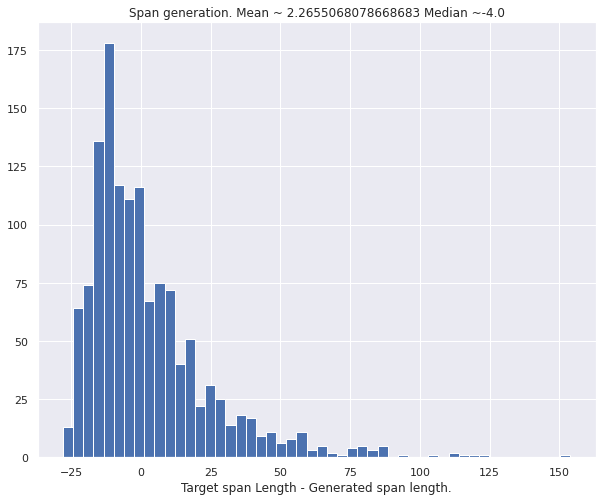

In [56]:
diff = [get_length_difference(x) for x in accumulated_data]

plt.hist(diff, bins=50)

plt.title(
    "Span generation. Mean ~ {} Median ~{}".format(
    sum(diff)/len(diff), np.median(diff))
)
plt.xlabel(
    "Target span Length - Generated span length."
)

In [57]:
# dom_lengths = [x for x in ]

In [35]:
.001* analysis_utils.get_length_variance_from_data(accumulated_data, tokenizer)

0.0005037375189107414

In [ ]:
np.mean([abs(tokenizer.tokenize(x["target"]).__len__() - avg_length)  for x in accumulated_data])

In [37]:
rouge = load_metric("rouge")

In [38]:
# dominant_data, reference_data = analysis_utils.split_data_by_citation_type(accumulated_data)

In [39]:
predicted = [analysis_utils.remove_citation_from_sentence(x["generated"], x["source"]) for x in accumulated_data]

reference = [analysis_utils.remove_citation_from_sentence(x["target"], x["source"]) for x in accumulated_data]

In [40]:
predicted[1]

' proposed a distillation-based distillation approach\nThis distillation is based on the distillation of all the models in a single distillation step'

In [41]:
reference[1]

' proposed to fine tune a multilingual model to a specified zeroshot-direction with pseudo-parallel data'

In [42]:
rouge.compute(
    predictions=predicted, 
    references=reference, 
    rouge_types=["rouge1","rouge2","rougeL"],
    use_stemmer=True
)

{'rouge1': AggregateScore(low=Score(precision=0.2772599041339654, recall=0.29695541973873824, fmeasure=0.26425983896424876), mid=Score(precision=0.28583858716884747, recall=0.306074768321172, fmeasure=0.2715437557668595), high=Score(precision=0.2948596186021861, recall=0.3150998270500466, fmeasure=0.27830572083795424)),
 'rouge2': AggregateScore(low=Score(precision=0.07405053189002031, recall=0.0802334250553994, fmeasure=0.07051513933336478), mid=Score(precision=0.07914633992595807, recall=0.08672514801471393, fmeasure=0.07550899355923901), high=Score(precision=0.08442027235012582, recall=0.09318375124249138, fmeasure=0.08068082482299987)),
 'rougeL': AggregateScore(low=Score(precision=0.20936910638239783, recall=0.23191266977355193, fmeasure=0.2026179095483752), mid=Score(precision=0.21591750131711807, recall=0.23912317094283175, fmeasure=0.2081367007095653), high=Score(precision=0.2227267775115336, recall=0.24786492728810786, fmeasure=0.21431070065934266))}

### Changing Desired Length Experiments

In [43]:
def run_model(batch, model, length=None):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=['[Dominant]', '[Reference]'],
        length=length
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}
    predicted_abstract_ids = model.generate(
        processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        **model_kwargs,
        output_scores=True,
        return_dict_in_generate = True,
        num_return_sequences = 1,
        
    )
    out = tokenizer.batch_decode(predicted_abstract_ids.sequences, skip_special_tokens=True)
    target = batch["target"]
    return out, target, predicted_abstract_ids.sequences_scores

In [44]:
def run_length_controlled_prediction(
    source, target = "dummy target", length=None
):
    """high level function for length controlled generation"""
    test_data = {"source": source, "target": target, "id": "test_123"}

    test_data_list = [test_data]
    
    for batch in DataLoader(test_data_list, batch_size = 1, shuffle=False):
        out, ta, seq_scores = run_model(
            batch, model,
            length=length
        )
        break
    return out[0], seq_scores[0].cpu().numpy().item()

In [51]:
length_configs = [10, 20, 30, 50, 80]


for data in tqdm(accumulated_data):
    source = data["source"]
    
    for len_option in length_configs:
        if "generated_{}".format(len_option) not in data:
            data["generated_{}".format(len_option)], data["generated_{}_score".format(len_option)] = run_length_controlled_prediction(
                source, length=len_option
            )

100%|██████████| 1322/1322 [2:07:09<00:00,  5.77s/it]  


In [61]:
# accumulated_data[0]

In [49]:
with open(os.path.abspath(os.path.join(path, "../vary_length_sample_output.json")), 'w') as f:
    json.dump(accumulated_data, f)

In [ ]:
run_length_controlled_prediction(source, length=20)

In [ ]:
run_length_controlled_prediction(source, length=30)

In [ ]:
run_length_controlled_prediction(source, length=100)

In [ ]:
source = """Recurrent neural network grammars (RNNGs) (Dyer et al., 2016) model sentences by first generating a nested, hierarchical syntactic structure which is used to construct a context representation to be conditioned upon for upcoming words. Supervised RNNGs have been shown to outperform standard sequential language models, achieve excellent results on parsing (Dyer et al., 2016; Kuncoro et al., 2017) , better encode syntactic properties of language , and correlate with electrophysiological responses in the human brain . However, these all require annotated syntactic trees for training. In this work, we explore unsupervised learning of recurrent neural network grammars for language modeling and grammar induction. Work done while the first author was an intern at DeepMind. Code available at https://github.com/harvardnlp/urnng The standard setup for unsupervised structure learning is to define a generative model p θ (x, z) over observed data x (e.g. sentence) and unobserved structure z (e.g. parse tree, part-of-speech sequence), and maximize the log marginal likelihood log p θ (x) = log z p θ (x, z). Successful approaches to unsupervised parsing have made strong conditional independence assumptions (e.g. context-freeness) and employed auxiliary objectives (Klein and Manning, 2002) or priors (Johnson et al., 2007) . These strategies imbue the learning process with inductive biases that guide the model to discover meaningful structures while allowing tractable algorithms for marginalization; however, they come at the expense of language modeling performance, particularly compared to sequential neural models that make no independence assumptions. Like RNN language models, RNNGs make no independence assumptions. Instead they encode structural bias through operations that compose linguistic constituents. The lack of independence assumptions contributes to the strong language modeling performance of RNNGs, but make unsupervised learning challenging. First, marginalization is intractable. Second, the biases imposed by the RNNG are relatively weak compared to those imposed by models like PCFGs. There is little pressure for non-trivial tree structure to emerge during unsupervised RNNG (URNNG) learning. In this work, we explore a technique for handling intractable marginalization while also injecting inductive bias. Specifically we employ amortized variational inference (Kingma and Welling, 2014; Rezende et al., 2014; Mnih and Gregor, 2014 ) with a structured inference network. Variational inference lets us tractably optimize a lower bound on the log marginal likelihood, while employing a structured inference network encourages non-trivial structure. In particular, a con-ditional random field (CRF) constituency parser (Finkel et al., 2008; Durrett and Klein, 2015) , which makes significant independence assumptions, acts as a guide on the generative model to learn meaningful trees through regularizing the posterior (Ganchev et al., 2010) . We experiment with URNNGs on English and Chinese and observe that they perform well as language models compared to their supervised counterparts and standard neural LMs. In terms of grammar induction, they are competitive with recently-proposed neural architectures that discover tree-like structures through gated attention (Shen et al., 2018) . Our results, along with other recent work on joint language modeling/structure learning with deep networks (Shen et al., 2018 (Shen et al., , 2019 Wiseman et al., 2018; Kawakami et al., 2018) , suggest that it is possible learn generative models of language that model the underlying data well (i.e. assign high likelihood to held-out data) and at the same time induce meaningful linguistic structure. </s> work (Cho et al., 2014; Chung et al., 2017; Shen et al., 2018 Shen et al., , 2019 .\nIn contrast,  [Dominant] \nOur work is also related to the recent line of work on learning latent trees as part of a deep model through supervision on other tasks, typically via differentiable structured hidden layers (Kim et al., 2017; Bradbury and Socher, 2017; Tran and Bisk, 2018; Peng et al., 2018; Niculae et al., 2018; , policy gradient-based approaches (Yogatama et al., 2017; Williams et al., 2018; Havrylov et al., 2019) , or differentiable relaxations (Choi et al., 2018; Maillard and Clark, 2018) .\n\n [B_Dominant] Buys and Blunsom (2018) </s> Neural Syntactic Generative Models with Exact Marginalization | We present neural syntactic generative models with exact marginalization that support both dependency parsing and language modeling. Exact marginalization is made tractable through dynamic programming over shiftreduce parsing and minimal RNN-based feature sets. Our algorithms complement previous approaches by supporting batched training and enabling online computation of next word probabilities. For supervised dependency parsing, our model achieves a stateof-the-art result among generative approaches. We also report empirical results on unsupervised syntactic models and their role in language modeling. We find that our model formulation of latent dependencies with exact marginalization do not lead to better intrinsic language modeling performance than vanilla RNNs, and that parsing accuracy is not correlated with language modeling perplexity in stack-based models. [E_Dominant]"""

In [ ]:
# val_set[0]

In [ ]:
run_length_controlled_prediction(source, length=20)

In [ ]:
run_length_controlled_prediction(source, length=30)

In [ ]:
run_length_controlled_prediction(source, length=50)

In [ ]:
source = """Recurrent neural network grammars (RNNGs) (Dyer et al., 2016) model sentences by first generating a nested, hierarchical syntactic structure which is used to construct a context representation to be conditioned upon for upcoming words. Supervised RNNGs have been shown to outperform standard sequential language models, achieve excellent results on parsing (Dyer et al., 2016; Kuncoro et al., 2017) , better encode syntactic properties of language , and correlate with electrophysiological responses in the human brain . However, these all require annotated syntactic trees for training. In this work, we explore unsupervised learning of recurrent neural network grammars for language modeling and grammar induction. Work done while the first author was an intern at DeepMind. Code available at https://github.com/harvardnlp/urnng The standard setup for unsupervised structure learning is to define a generative model p θ (x, z) over observed data x (e.g. sentence) and unobserved structure z (e.g. parse tree, part-of-speech sequence), and maximize the log marginal likelihood log p θ (x) = log z p θ (x, z). Successful approaches to unsupervised parsing have made strong conditional independence assumptions (e.g. context-freeness) and employed auxiliary objectives (Klein and Manning, 2002) or priors (Johnson et al., 2007) . These strategies imbue the learning process with inductive biases that guide the model to discover meaningful structures while allowing tractable algorithms for marginalization; however, they come at the expense of language modeling performance, particularly compared to sequential neural models that make no independence assumptions. Like RNN language models, RNNGs make no independence assumptions. Instead they encode structural bias through operations that compose linguistic constituents. The lack of independence assumptions contributes to the strong language modeling performance of RNNGs, but make unsupervised learning challenging. First, marginalization is intractable. Second, the biases imposed by the RNNG are relatively weak compared to those imposed by models like PCFGs. There is little pressure for non-trivial tree structure to emerge during unsupervised RNNG (URNNG) learning. In this work, we explore a technique for handling intractable marginalization while also injecting inductive bias. Specifically we employ amortized variational inference (Kingma and Welling, 2014; Rezende et al., 2014; Mnih and Gregor, 2014 ) with a structured inference network. Variational inference lets us tractably optimize a lower bound on the log marginal likelihood, while employing a structured inference network encourages non-trivial structure. In particular, a con-ditional random field (CRF) constituency parser (Finkel et al., 2008; Durrett and Klein, 2015) , which makes significant independence assumptions, acts as a guide on the generative model to learn meaningful trees through regularizing the posterior (Ganchev et al., 2010) . We experiment with URNNGs on English and Chinese and observe that they perform well as language models compared to their supervised counterparts and standard neural LMs. In terms of grammar induction, they are competitive with recently-proposed neural architectures that discover tree-like structures through gated attention (Shen et al., 2018) . Our results, along with other recent work on joint language modeling/structure learning with deep networks (Shen et al., 2018 (Shen et al., , 2019 Wiseman et al., 2018; Kawakami et al., 2018) , suggest that it is possible learn generative models of language that model the underlying data well (i.e. assign high likelihood to held-out data) and at the same time induce meaningful linguistic structure. </s> work (Cho et al., 2014; Chung et al., 2017; Shen et al., 2018 Shen et al., , 2019 .\nIn contrast, Buys and Blunsom (2018) make Markov assumptions and perform exact marginalization over latent dependency trees.\nOur work is also related to the recent line of work on learning latent trees as part of a deep model through supervision on other tasks, typically via differentiable structured hidden layers (Kim et al., 2017; Bradbury and Socher, 2017; Tran and Bisk, 2018; Peng et al., 2018; Niculae et al., 2018; , policy gradient-based approaches (Yogatama et al., 2017; Williams et al., 2018; Havrylov et al., 2019) , or  [Reference]  .\n\n [B_Reference] (Choi et al., 2018; </s> Learning to Compose Task-Specific Tree Structures | For years, recursive neural networks (RvNNs) have been shown to be suitable for representing text into fixed-length vectors and achieved good performance on several natural language processing tasks. However, the main drawback of RvNNs is that they require structured input, which makes data preparation and model implementation hard. In this paper, we propose Gumbel Tree-LSTM, a novel treestructured long short-term memory architecture that efficiently learns how to compose task-specific tree structures only from plain text data. Our model uses Straight-Through Gumbel-Softmax estimator to decide the parent node among candidates dynamically and to calculate gradients of the discrete decision. We evaluate the proposed model on natural language inference and sentiment analysis, and show that our model outperforms or is at least comparable to previous models. We also find that our model converges significantly faster than other models. [E_Reference] [B_Reference] Maillard and Clark, 2018) </s> Latent Tree Learning with Differentiable Parsers: Shift-Reduce Parsing and Chart Parsing | Latent tree learning models represent sentences by composing their words according to an induced parse tree, all based on a downstream task. These models often outperform baselines which use (externally provided) syntax trees to drive the composition order. This work contributes (a) a new latent tree learning model based on shift-reduce parsing, with competitive downstream performance and non-trivial induced trees, and (b) an analysis of the trees learned by our shift-reduce model and by a chart-based model. [E_Reference]"""

In [ ]:
run_length_controlled_prediction(source, length=20)

In [ ]:
run_length_controlled_prediction(source, length=30)

In [ ]:
run_length_controlled_prediction(source, length=50)